# Define Poisson equation

## Import modules

In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import matplotlib.pyplot as plt
import numpy as np
from discretize import TensorMesh
from discretize.utils import mkvc

from simpeg_ecosys.mathematical import PoissonCellCentered, VolumeSource

# Suppress all warnings
warnings.filterwarnings('ignore')

## Set the mesh

In [2]:
delta = 1
hx = np.ones(5) * delta
origin = [0]
mesh = TensorMesh([hx], origin=origin)
bc_types = [["dirichlet", "dirichlet"]]
bc_values = [[0, 0]]
print(mesh)


  TensorMesh: 5 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      5          0.00          5.00      1.00      1.00    1.00




## Set the model parameters (diffusion coefficient)

In [3]:
# uniform medium
model_parameters = mkvc(1 * np.ones(mesh.n_cells))

## Set the source term

In [4]:
source1 = VolumeSource([[mesh.cell_centers_x[(mesh.n_cells//2)]]], values=[1])
source_list = [source1]

print(source_list)

[
       locations    |        values
--------------------+------------------
    [    2.5000]    |        1.0000    
]


## Create an instance of `PoissonCellCentered`

In [5]:
poisson = PoissonCellCentered(
    mesh, bc_types, bc_values,
    source_list=source_list,
    model_parameters=model_parameters
)

# Solve Poisson equation using conventional numerical methods

## Import modules

In [6]:
import scipy.sparse as sp
import scipy.sparse.linalg

## Solve Poisson equation by `scipy.sparse.linalg.splu` and `scipy.sparse.linalg.spsolve`

In [7]:
A = poisson.getA().toarray()
b = poisson.getRHS()
print(f"A:\n{A}")
print(f"b:\n{b}")

lu = sp.linalg.splu(A)
x_lu = lu.solve(b)
x = sp.linalg.spsolve(A, b)
if not np.all(np.isclose(x_lu, x)):
    raise ArithmeticError

A:
[[ 3. -1.  0.  0.  0.]
 [-1.  2. -1.  0.  0.]
 [ 0. -1.  2. -1.  0.]
 [ 0.  0. -1.  2. -1.]
 [ 0.  0.  0. -1.  3.]]
b:
[0. 0. 1. 0. 0.]


## Show result

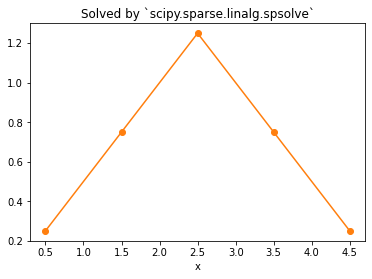

x:
[0.25 0.75 1.25 0.75 0.25]


In [8]:
mesh.plot_image(x)
plt.title("Solved by `scipy.sparse.linalg.spsolve`")
plt.show()
print(f"x:\n{x}")

# Solve Poisson equation using Simulated Annealing or Quantum Annealing (Direct QPU)

## Import modules

In [9]:
from neal import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite, DWaveSampler

from dwaveutils import bl_lstsq

## Create an instance of `BlLstsqProblem`

In [10]:
problem_params = {"A": A, "b": b}
qubo_params = {
    "num_bits": 4,
    "fixed_point": 1,
    "sign": "pn",
    "eq_scaling_val": 1/8,
}
problem = bl_lstsq.problem.BlLstsqProblem(problem_params, qubo_params)

## Create an instance of `BlLstsqDirectSolver`

In [11]:
solver = bl_lstsq.solver.BlLstsqDirectSolver(problem)

## Set sampler and parameters for `BlLstsqDirectSolver.solve` method

In [12]:
sampler = SimulatedAnnealingSampler()
# sampler = EmbeddingComposite(
#     DWaveSampler(solver={'qpu': True}, postprocess="sampling")
# )  # use postprocess
sampling_params = {
    "num_reads": 1000,
    "chain_strength": 100,  # no effect on SA
    "answer_mode": "histogram"
}

## Solve

In [13]:
result = solver.solve(sampler=sampler, sampling_params=sampling_params)
x_directsolver = result["x"]

## Show result

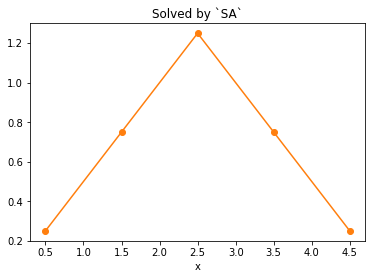

x:
[0.25 0.75 1.25 0.75 0.25]


In [14]:
mesh.plot_image(x_directsolver)
plt.title("Solved by `SA`")
# plt.title("Solved by `QA (Direct QPU)`")
plt.show()
print(f"x:\n{x_directsolver}")

# Solve Poisson equation using Simulated Annealing or Quantum Annealing (Direct QPU) through an iterative procedure

## Create an instance of `BlLstsqProblem`

In [15]:
problem_params = {"A": A, "b": b}
qubo_params = {
    "num_bits": 2,
    "fixed_point": 1,
    "sign": "p",
    "eq_scaling_val": 1/8,
}
problem = bl_lstsq.problem.BlLstsqProblem(problem_params, qubo_params)

## Create an instance of `BlLstsqIterativeSolver`

In [16]:
solver = bl_lstsq.BlLstsqIterativeSolver(problem)

## Set initial x, sampler and parameters for `BlLstsqIterativeSolver.solve` method

In [17]:
sampler = SimulatedAnnealingSampler()
# sampler = EmbeddingComposite(
#     DWaveSampler(solver={'qpu': True}, postprocess="sampling")
# )  # use postprocess
sampling_params = {
    "num_reads": 1000,
    "chain_strength": 100,  # no effect on SA
    "answer_mode": "histogram"
}
iter_params = {
    "scale_factor": 2,
    "num_iter": 20,
    "obj_tol": 1e-3,
    "verbose": True
}
rng = np.random.default_rng(1234)
initial_x = (1 - (-1)) * rng.random(b.size) + (-1)

## Solve

In [18]:
result = solver.solve(
    initial_x,
    sampler=sampler,
    sampling_params=sampling_params,
    iter_params=iter_params
)
x_iterativesolver = result["x"]

Iteration: 0
  - x: [ 0.9534 -0.2396  0.8465 -0.4766 -0.3618]
  - qubo_obj: nan
  - obj: 4.38488959e+00
Iteration: 1
  - x: [-0.0466 -0.2396 -0.1535 -0.4766 -0.3618]
  - qubo_obj: -9.46872194e-01
  - obj: 9.99654676e-01
Iteration: 2
  - x: [-0.0466 -0.2396 -0.1535 -0.4766 -0.3618]
  - qubo_obj: -1.19087326e+00
  - obj: 9.99654676e-01
Iteration: 3
  - x: [-0.0466  0.2048  0.2909 -0.0322  0.0826]
  - qubo_obj: -1.32332069e+00
  - obj: 8.74851252e-01
Iteration: 4
  - x: [-0.0466  0.2048  0.7354  0.4123  0.0826]
  - qubo_obj: -1.11860943e+00
  - obj: 4.95126601e-01
Iteration: 5
  - x: [-0.0466  0.2048  0.7354  0.4123  0.0826]
  - qubo_obj: -1.42946484e+00
  - obj: 4.95126601e-01
Iteration: 6
  - x: [0.1509 0.4024 0.9329 0.4123 0.0826]
  - qubo_obj: -1.72315851e+00
  - obj: 3.82831709e-01
Iteration: 7
  - x: [0.1509 0.5999 0.9329 0.4123 0.0826]
  - qubo_obj: -1.16547048e+00
  - obj: 3.46408124e-01
Iteration: 8
  - x: [0.1509 0.4682 0.9329 0.544  0.2143]
  - qubo_obj: -1.70534215e+00
  - obj

## Show result

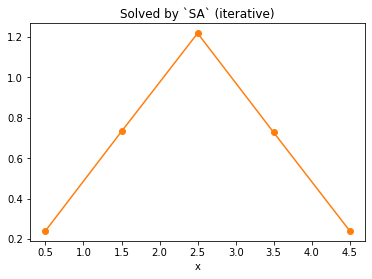

x:
[0.24034766 0.73266873 1.21904746 0.72767281 0.2403381 ]


In [19]:
mesh.plot_image(x_iterativesolver)
plt.title("Solved by `SA` (iterative)")
# plt.title("Solved by `QA (Direct QPU/iterative)`")
plt.show()
print(f"x:\n{x_iterativesolver}")